## <font color = 'green' id = "section" > Télémarketing  & Interprétabilité locale par lime </font>

# <font color="blue">Sommaire</font>
1. [Lecture du Dataset](#section_1)     
2. [Data preparation](#section_2)     
3. [Liaison entre les variables](#section_3)       

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#----------------------------------------
from tqdm  import tqdm
#--------------------------------------
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


In [3]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

## Description Générale
Les données sont liées aux campagnes de marketing direct d'une institution bancaire portugaise. Les campagnes marketing étaient basées sur des appels téléphoniques. Souvent, plusieurs contacts avec le même client étaient nécessaires pour savoir si le produit (dépôt à terme bancaire) serait (« oui ») ou non (« non ») souscrit.

## Variable Description and Values
##### Personal Client Information
* **Age** : Age at the contact date (Numeric ≥18)

* **Marital status**:  Married, single, divorced, widowed, separated (Nominal)

* **Sex**:  Male or Female (Nominal)

* **Education** : Customer's leve of education

* **Default** :  Has credit undefault : Le client n'a pas de defaut de credit

* **Housing** : Has housing loan : Le client a un prêt immobilier oui ou non ?

* **Contact** : Moyen de contact


#####  Bank Client Information

* **balance (Numeric)** : Solde bancaire au moment de la campagne

* **Loan** :  Yes or No (Nominal) : A des pret personnel ?

##### Last Contact Information

* **Date and time** : Referring to when the contact was made (Month and Days)

* **Duration Of the contact** (in seconds)

* **poutcome** : Résultat de la campagne de marketing de contact précédente

* **pdays**: Nombre de jours écoulés après que le client ait été contacté pour la dernière fois lors d'une campagne précédente

* **Previous** : Nombre de contacts effectués avant cette campagne et pour ce client

* **Campaign** : Nombre de contacts effectués durant cette campagne et pour ce client

###### L'objectif :

* C'est de prédire si le client souscrira (oui/non) un dépôt à terme (variable y)

* Interpréter le modéle localement avec LIME


## <font color="red" id="section_1"> 1. Chargement, lecture  et apercu  des données</font>

In [4]:
data = pd.read_csv('bank.csv', sep =  (","))

In [5]:
data.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,False,1787,False,False,cellular,19,oct,79,1,-1,0,unknown,False
1,33,services,married,secondary,False,4789,True,True,cellular,11,may,220,1,339,4,failure,False
2,35,management,single,tertiary,False,1350,True,False,cellular,16,apr,185,1,330,1,failure,False


In [6]:
data.shape

(4521, 17)

In [7]:
data.dtypes.value_counts()

int64     7
object    6
bool      4
Name: count, dtype: int64

In [8]:
data.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
data.duplicated().sum()

0

### <font color="red" id="section_2"> 2. Data préparation 

**Compréhension des données** :
Ce petit ensemble de données (4521 lignes et 17 colonnes) est bien suffisant pour lancer la modélisation. Toutes les variables jouent un role important néanmons pour alléger encore plus le projet, on va selectionner quelques variables pertinentes pour que notre prediction répond au mieux l'objectif souhaité.

**La problèmatique business** c'est évidemment maximiser le **ROI**, rentablilité la campagne mais nous, on se restreindra plutôt à interpréter localement le modéle de machine learning. Il y'a énormément de chose à faire mais ce n'est pas  l'objectif.




In [10]:
data.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,False,1787,False,False,cellular,19,oct,79,1,-1,0,unknown,False
1,33,services,married,secondary,False,4789,True,True,cellular,11,may,220,1,339,4,failure,False


In [11]:
data.poutcome.unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [12]:
del data['day']
del data['month']
del data['poutcome']

**Descrition statistique**

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.170095,10.576211,19.0,33.0,39.0,49.0,87.0
balance,4521.0,1422.657819,3009.638142,-3313.0,69.0,444.0,1480.0,71188.0
duration,4521.0,263.961292,259.856633,4.0,104.0,185.0,329.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.0,2.0,3.0,50.0
pdays,4521.0,39.766645,100.121124,-1.0,-1.0,-1.0,-1.0,871.0
previous,4521.0,0.542579,1.693562,0.0,0.0,0.0,0.0,25.0


## Commentaire :
On rappelle que **pdays** est le nombre de jours écoulés après que le client ait été contacté pour la dernière fois lors d'une campagne précédente, donc nous allons remplacer $-1$ apr $0$.

On va également transformer les durées d'appels en mimutes.

On va normaliser les données plus tard avant de passer lancer la prédiction.

In [14]:
data['duration'] = data['duration']/60

**Traitement de pdays**

In [15]:
data.pdays.unique()[:5]

array([ -1, 339, 330, 176, 147], dtype=int64)

In [16]:
def treatment_pdays(df,col = 'pdays'):
    for ind, val  in enumerate(df[col]) :
        if val == -1 :
            df.loc[df[col]== -1, col] = 0    
    return df

In [17]:
data = treatment_pdays(data)

In [18]:
data.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,y
0,30,unemployed,married,primary,False,1787,False,False,cellular,1.316667,1,0,0,False
1,33,services,married,secondary,False,4789,True,True,cellular,3.666667,1,339,4,False


**Encodage des booleéns** en 0  ou 1: **False = 0**, **True = 1**

* **target y**
* **default** 
* **housing**
* **loan** 


On va utiliser la **methode appy**, **methode lambda** pour encoder les colonnes booléens et **OnehotEncoder** pour  les autres colonnes catégorielles.

In [19]:
def encodage_boolean(val):
    if val :
        return 1
    else :
        return 0

In [20]:
data['y'] = data['y'].apply(lambda x: 1 if x else 0)
data['default'] = data['default'].apply(lambda x: 1 if x else 0)

data['housing'] = data['housing'].apply(encodage_boolean)
data['loan'] = data['loan'].apply(encodage_boolean)

In [21]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,1.316667,1,0,0,0
1,33,services,married,secondary,0,4789,1,1,cellular,3.666667,1,339,4,0
2,35,management,single,tertiary,0,1350,1,0,cellular,3.083333,1,330,1,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3.316667,4,0,0,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,3.766667,1,0,0,0


In [22]:
data_copy = data.copy()

**Valeurs uniques**

In [23]:
## créer un dataframe avec des colonnes de type d'objet
unique_df = pd.DataFrame(data.select_dtypes('object').nunique()).reset_index()
unique_df.columns = ['Column','Nombre de  valeurs uniques']
unique_df['Valeurs uniques'] = unique_df['Column'].apply(lambda x: data[x].unique())
unique_df.sort_values(by='Nombre de  valeurs uniques')

,Column,Nombre de valeurs uniques,Valeurs uniques
1,marital,3,"[married, single, divorced]"
3,contact,3,"[cellular, unknown, telephone]"
2,education,4,"[primary, secondary, tertiary, unknown]"
0,job,12,"[unemployed, services, management, blue-collar..."


**Encoage des catégorielles**

In [24]:
data.dtypes.value_counts()

int64      9
object     4
float64    1
Name: count, dtype: int64

In [25]:
def one_hot_encoder(df, nan_as_category = True): # Add a column to indicate NaNs, if False NaNs are ignored.
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.select_dtypes('object').columns]
    
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category,  dtype=float)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [26]:
data, new_columns = one_hot_encoder(data, nan_as_category = False) 

In [27]:
data.head(3)

,age,default,balance,housing,loan,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown
0,30,0,1787,0,0,1.316667,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,33,0,4789,1,1,3.666667,1,339,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,35,0,1350,1,0,3.083333,1,330,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


**Obervation de la cible y**

In [28]:
data.y.value_counts()

y
0    4000
1     521
Name: count, dtype: int64

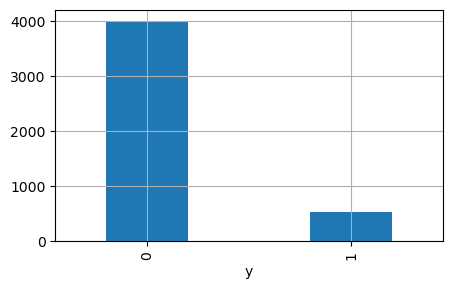

In [29]:
data.y.value_counts().plot(kind = 'bar', figsize = (5,3), width = 0.4)
plt.grid(True)

## Commentaire :
Les données sont déséquilibrées, nous allons gonflées artificiellement dans l'entrainement du model avec **SMOTE**.



**Distribution**

In [30]:
def ajust_graph():
    plt.subplots_adjust(left=0,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

32it [00:05,  5.81it/s]


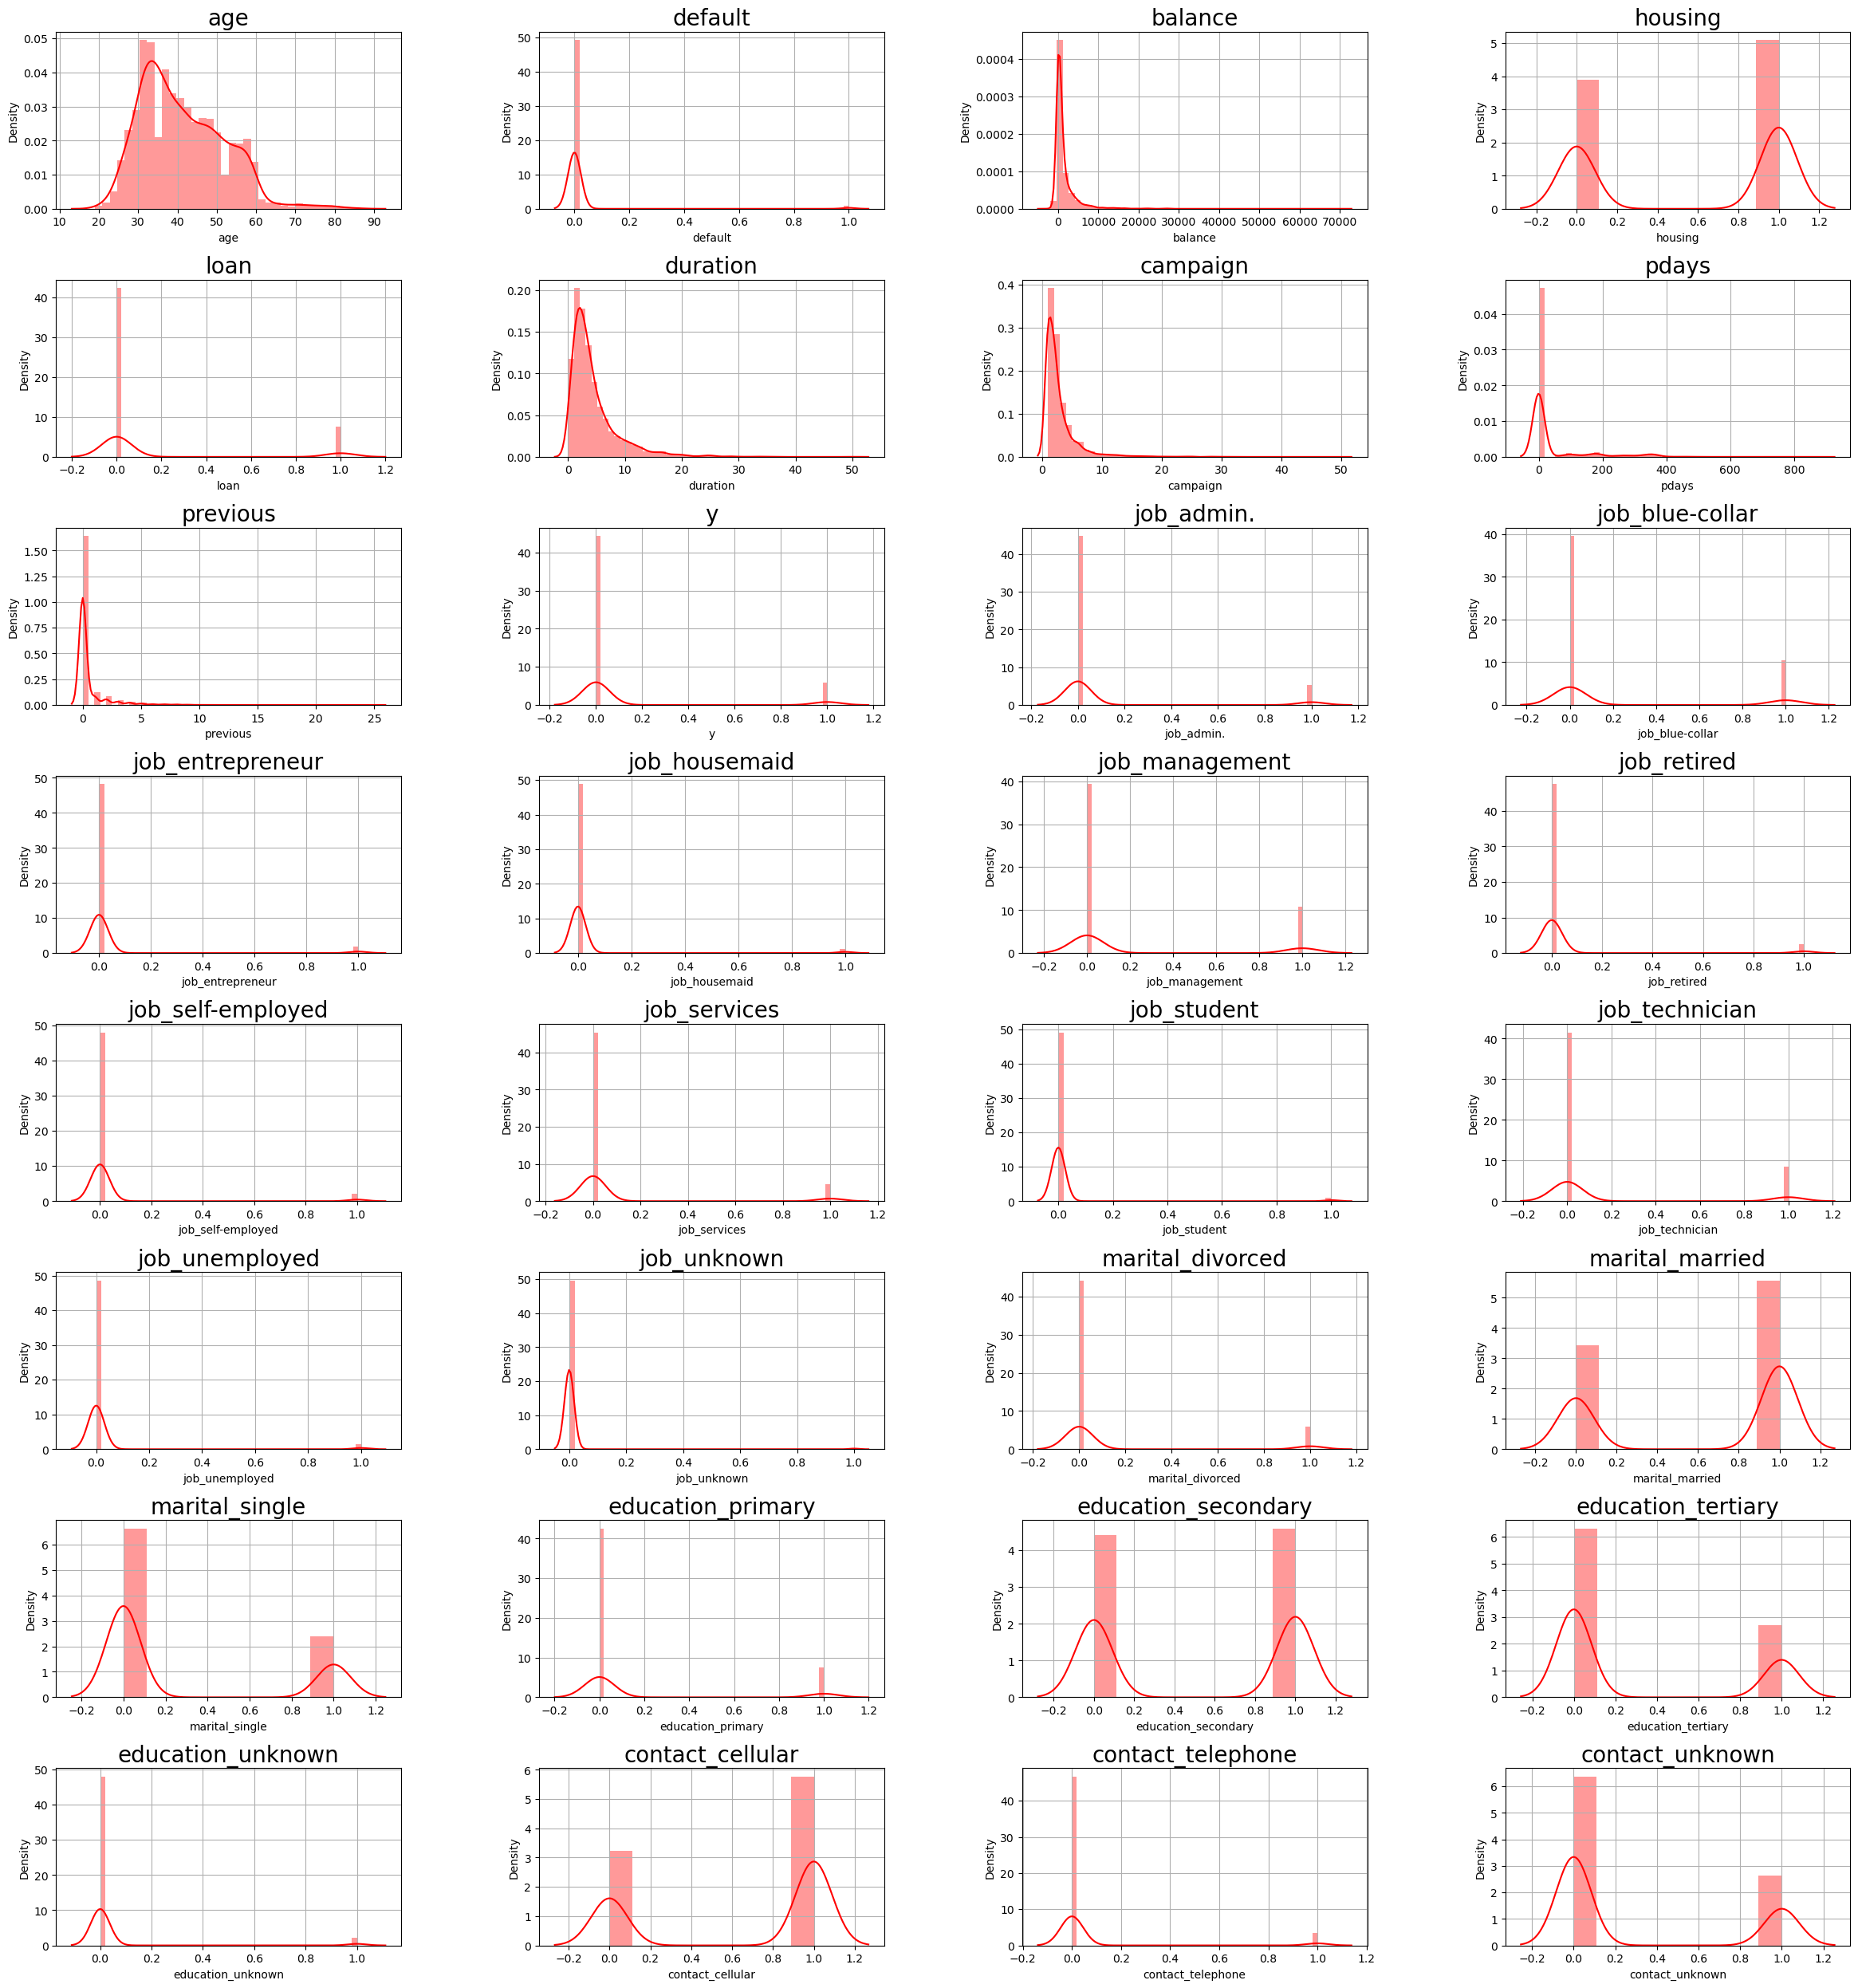

In [31]:
# Affichage des ditribution 
plt.figure(figsize=(25, 30))
df_numeric = data.select_dtypes(include =['float', 'int'])
for i, col in tqdm(enumerate(df_numeric)):
    plt.subplot(8, 4, i+1)
    ajust_graph()
    sns.distplot(df_numeric[col], color = 'red')
    plt.title(col, fontsize =20)
    plt.grid(True)

## Commentaire :

Les données ne sont pas distribuées normalement, autrement dit la moyenne et la médiane ne sont pas égales et la majorité des clients sont entre 20 et 60 ans, donc en activité professionnelle ou sont des étudiants

**EDP courte**

In [32]:
data.head(2)

,age,default,balance,housing,loan,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown
0,30,0,1787,0,0,1.316667,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,33,0,4789,1,1,3.666667,1,339,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


**Répartion du solde bancaire des clients en fonction du résultats de la campagne**

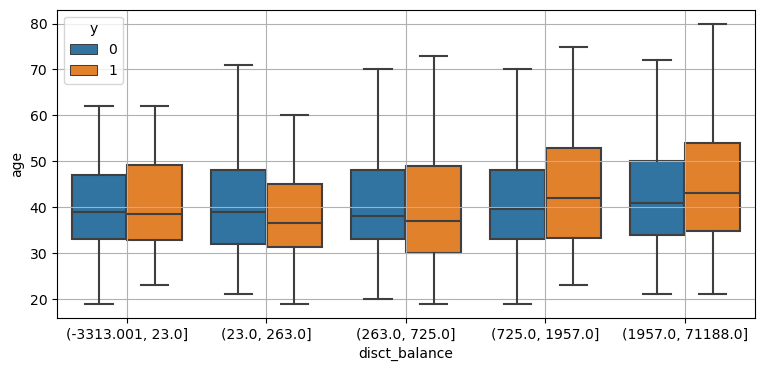

In [33]:
plt.figure(figsize =(9, 4))
data['disct_balance'] = pd.qcut(data['balance'], 5)
sns.boxplot(data =data, x = 'disct_balance', y = 'age', hue ="y" , showfliers = False)
plt.grid(True)
plt.show()

## Commentaire:

* D'abord, il faut remarquer que la plupart des clients qui ont souscrit ou non sont agés entre 33 et 50 ans.
* En suite, plus le solde bancaire client est élevé i.e plus de 725$, plus on souscrit au dépot bancaire bancaire proposé durant la camapagne.

**Distribution des fréquences de souscits ou non  en focntion de la situation maritale**

3it [00:00, 16.30it/s]


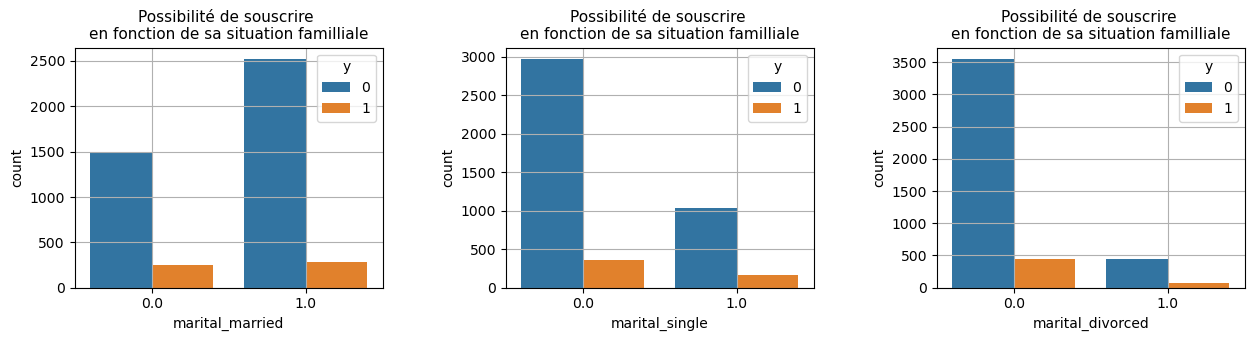

In [34]:
marital = ["marital_married", "marital_single", 'marital_divorced']  
plt.figure(figsize =(13,3))
for i, col in tqdm(enumerate(data[marital])):
    plt.subplot(1, 3, i+1)
    ajust_graph()
    sns.countplot(data = data,  x = data[col], hue = data["y"].astype(str))
    plt.title('Possibilité de souscrire \nen fonction de sa situation familliale', fontsize =11)
    plt.grid(True)


## Commentaire : 
En résumé, il y a plus de fréquences de clients non souscrits chez les mariés que les autres catégories (Seuls ou dovorcés).

### <font color="red" id="section_3"> 3. Liaison entre les variables
**Corrélation pour éviter la fuite des données**

In [35]:
del data['disct_balance']

<Axes: >

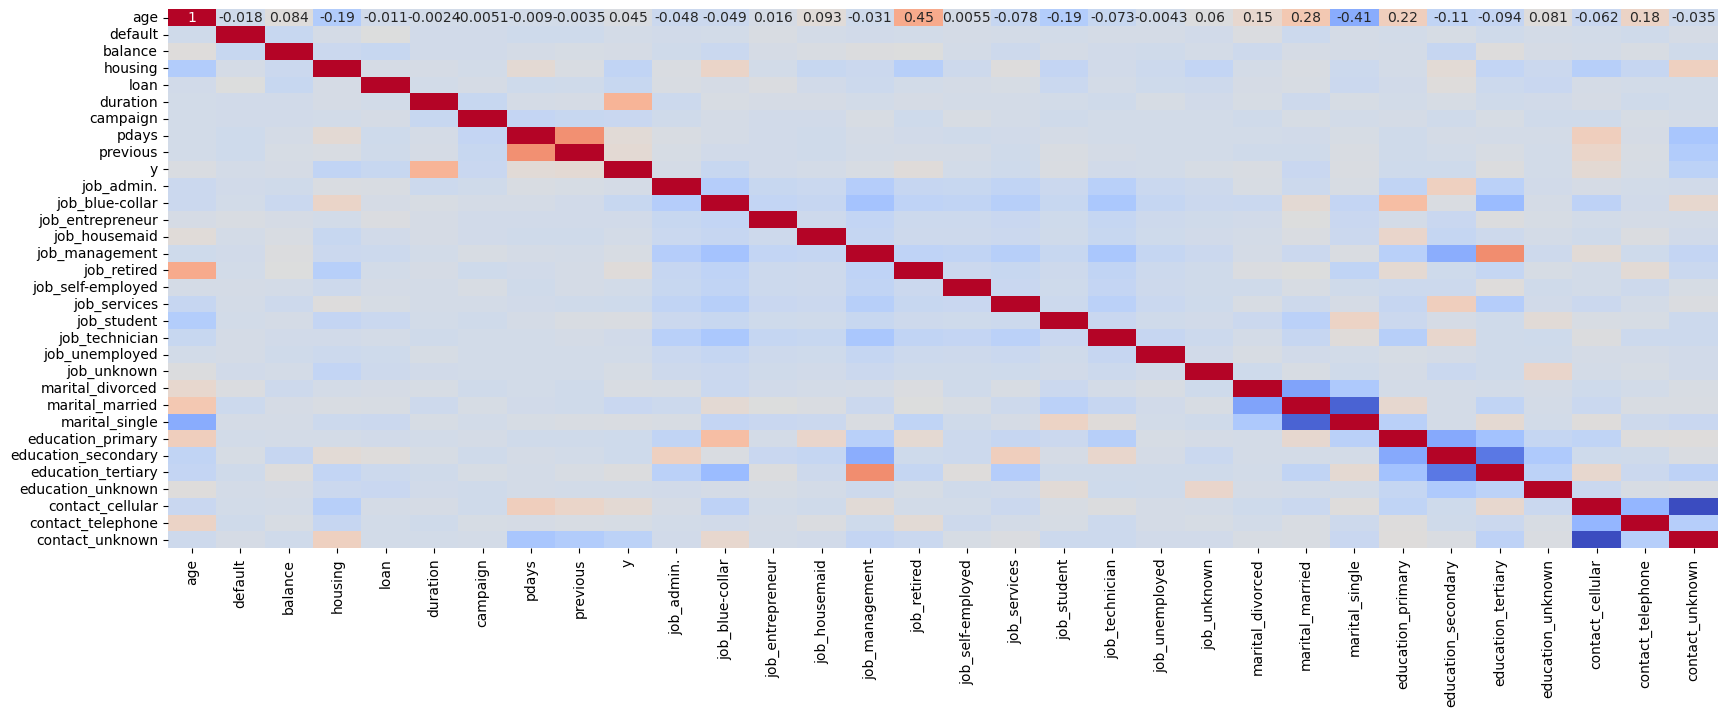

In [36]:
plt.figure(figsize =(20,7))
sns.heatmap(data.corr(), cmap = 'coolwarm', annot = True, cbar = False)

## Commentaire : 
Tout est bon pour commencer la modélisation. Pour alléger le cachier, on le fera sur un autre cahier.

In [37]:
data.to_csv('data_mod.csv', index =False)